In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
data = pd.read_csv('Dataset salary 2024.csv')

In [49]:
data.shape

(16534, 11)

In [50]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,SE,FT,AI Engineer,202730,USD,202730,US,0,US,M
1,2024,SE,FT,AI Engineer,92118,USD,92118,US,0,US,M
2,2024,SE,FT,Data Engineer,130500,USD,130500,US,0,US,M
3,2024,SE,FT,Data Engineer,96000,USD,96000,US,0,US,M
4,2024,SE,FT,Machine Learning Engineer,190000,USD,190000,US,0,US,M


In [51]:
data.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16534 entries, 0 to 16533
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           16534 non-null  int64 
 1   experience_level    16534 non-null  object
 2   employment_type     16534 non-null  object
 3   job_title           16534 non-null  object
 4   salary              16534 non-null  int64 
 5   salary_currency     16534 non-null  object
 6   salary_in_usd       16534 non-null  int64 
 7   employee_residence  16534 non-null  object
 8   remote_ratio        16534 non-null  int64 
 9   company_location    16534 non-null  object
 10  company_size        16534 non-null  object
dtypes: int64(4), object(7)
memory usage: 1.4+ MB


In [53]:
# Downsample the dataset for quicker iteration (use a smaller fraction of the data)
data_sampled = data.sample(frac=0.1, random_state=42)

# Feature Engineering

In [54]:
# Drop salary_currency as it is redundant with salary_in_usd
data_sampled = data_sampled.drop('salary_currency', axis=1)

In [55]:
# Define categorical and numerical features
categorical_features = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size']
numerical_features = ['work_year', 'remote_ratio']

In [56]:
# Preprocessing pipeline for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [57]:
# Define the full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))  # Utilize multiple cores
])

In [58]:
# Target variable
target = 'salary_in_usd'
X = data_sampled.drop(target, axis=1)
y = data_sampled[target]

In [59]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# Fit and transform the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['work_year',
                                                   'remote_ratio']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['experience_level',
                                                   'employment_type',
                                                   'job_title',
                                                   'employee_residence',
                                                   'company_location',
                                                   'company_size'])])),
                ('regressor',
                 RandomForestRegressor(n_jobs=-1, random_state=42))])

In [61]:
# Cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-validation R-squared scores: {cv_scores}")
print(f"Mean cross-validation R-squared: {cv_scores.mean()}")

Cross-validation R-squared scores: [0.17896463 0.31446303 0.15208757 0.32682356 0.22998766]
Mean cross-validation R-squared: 0.24046529147257178


# Hyperparameter Tuning

In [62]:
# Reduced parameter grid for quicker search
param_dist = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_features': ['auto', 'sqrt'],
    'regressor__max_depth': [10, 50],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2],
    'regressor__bootstrap': [True, False]
}

In [63]:
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1, error_score='raise')
random_search.fit(X_train, y_train)
print(f"Best parameters from Random Search: {random_search.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters from Random Search: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 50, 'regressor__bootstrap': False}


In [64]:
# Evaluate the model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

In [65]:
# Mean Squared Error, Root Mean Squared Error, R-squared
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [66]:
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 2956470400.7552304
Root Mean Squared Error (RMSE): 54373.43469705799
R-squared (R2): 0.27899457158050167


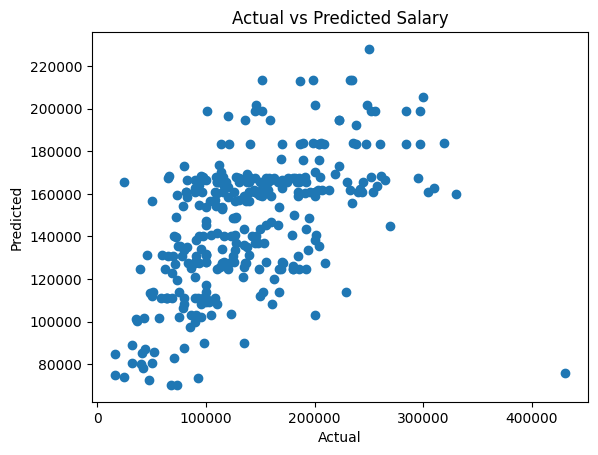

In [67]:
# Plot actual vs predicted
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Salary')
plt.show()

In [68]:
# Feature Importances
feature_importances = best_model.named_steps['regressor'].feature_importances_
feature_names = numerical_features + list(best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

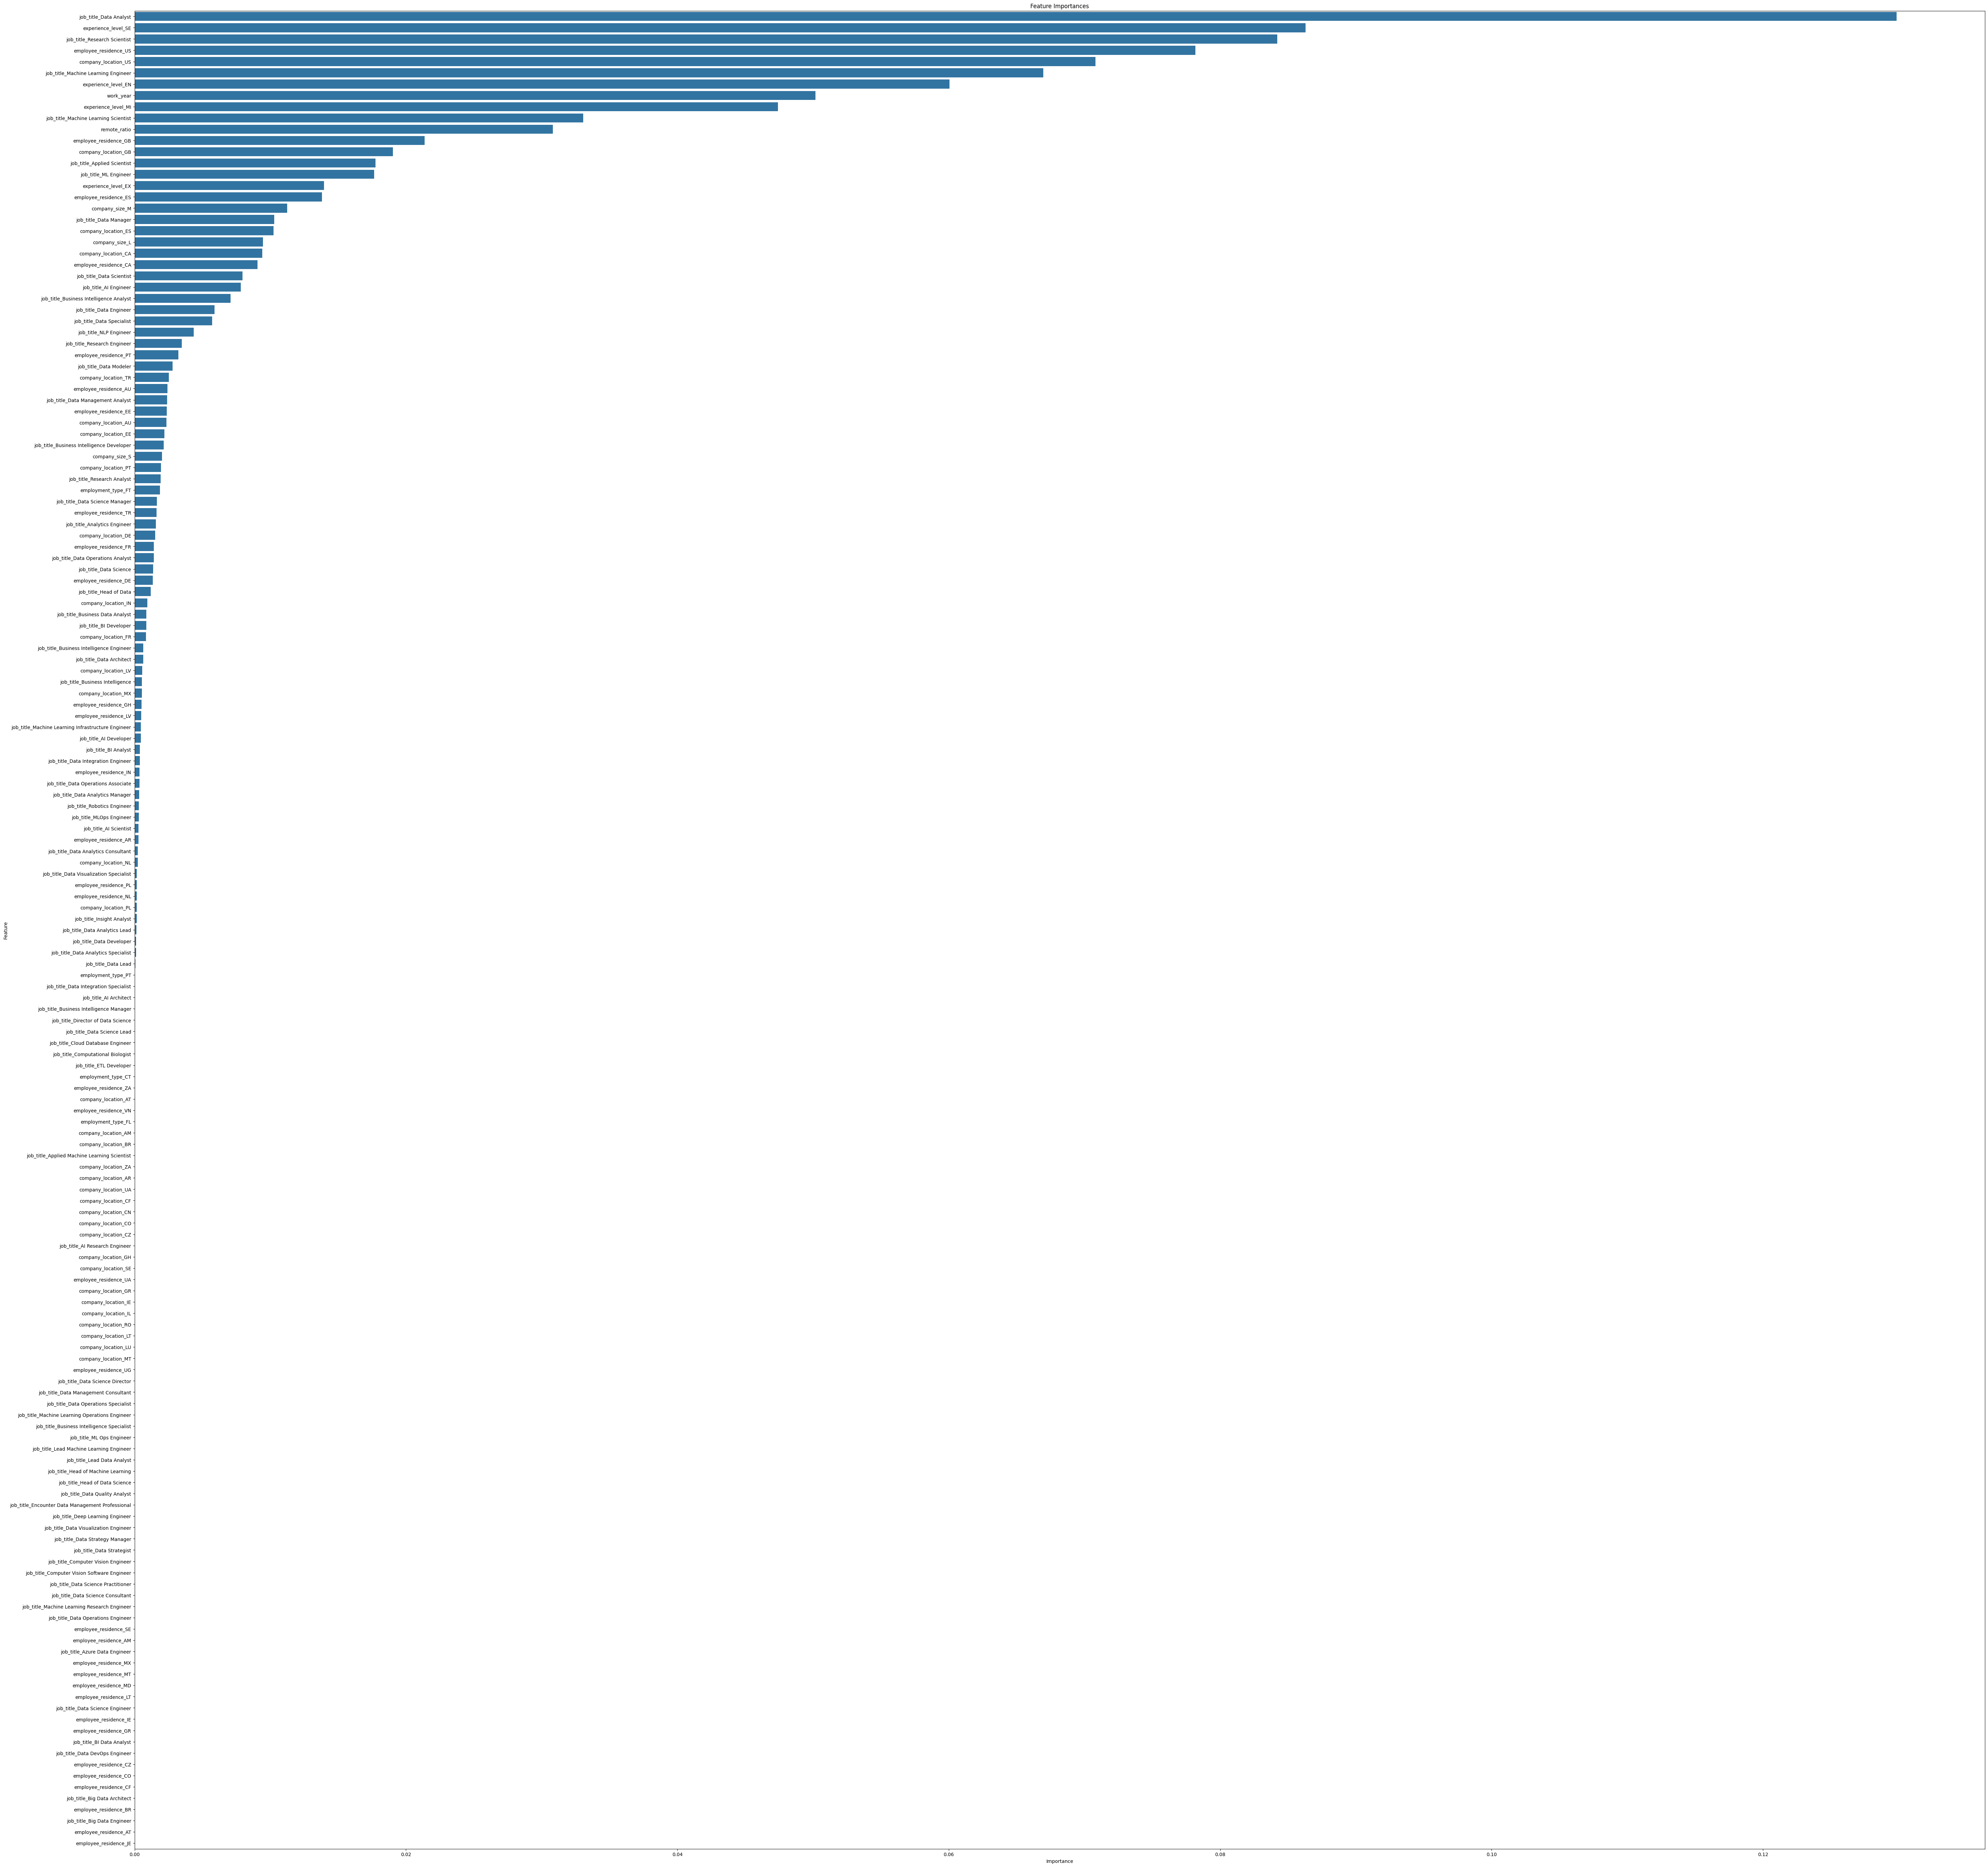

In [74]:
plt.figure(figsize=(70, 70))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()